## Set-up environment

First, we install 🤗 Transformers, Datasets and SentencePiece (the latter is used for tokenization).

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 20.8 MB/s eta 0:00:00


In [2]:
!pip install -q datasets sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 14.2 MB/s eta 0:00:00


## Load image

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from PIL import Image

N = 2
dir_path = "/content/drive/MyDrive/DONUT/dataset"
images = [Image.open(dir_path + "/img{}.jpeg".format(i + 1)) for i in range(N)]

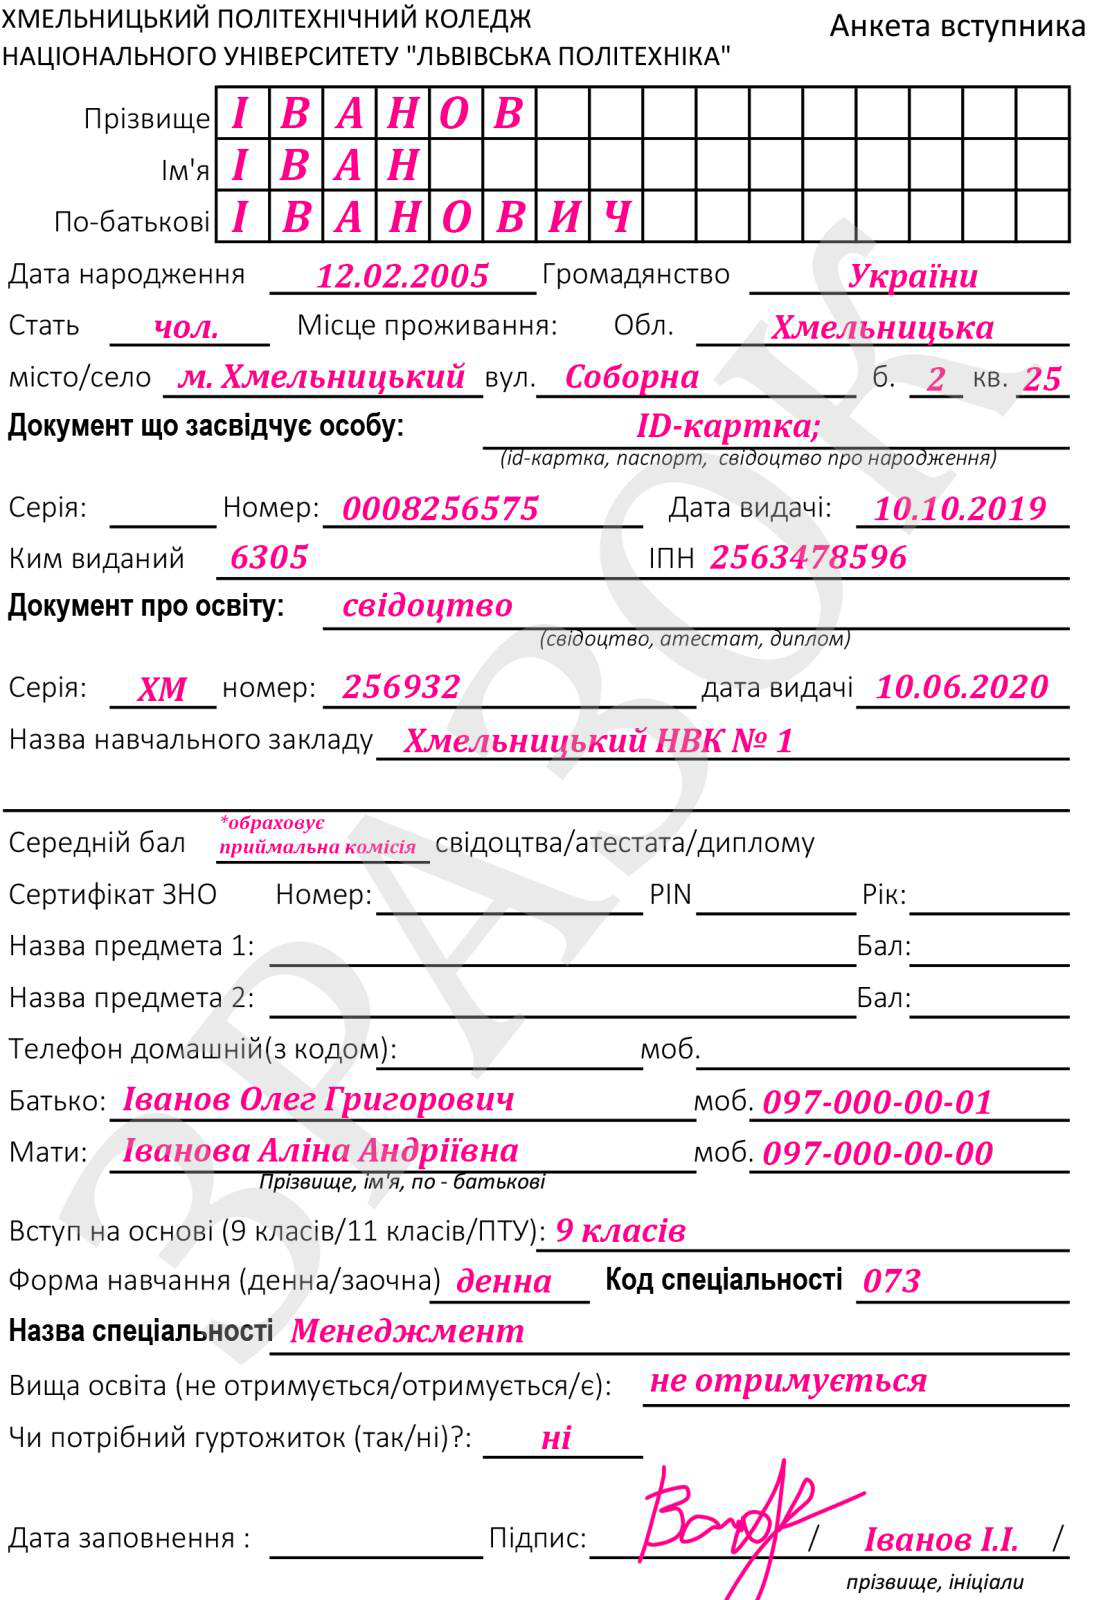

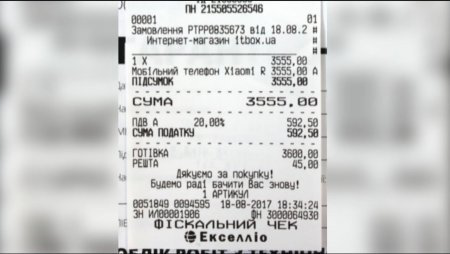

In [10]:
for image in images:
  display(image)

## Load model and processor

In [11]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

Downloading:   0%|          | 0.00/362 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Downloading:   0%|          | 0.00/536 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.02M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806M [00:00<?, ?B/s]

## Prepare using processor

We prepare the image for the model using `DonutProcessor`.

In [12]:
inputs = []
for image in images:
  pixel_values = processor(image, return_tensors="pt").pixel_values
  print(pixel_values.shape)
  inputs.append(pixel_values)

torch.Size([1, 3, 1280, 960])
torch.Size([1, 3, 1280, 960])


## Generate

Finally, we let the model autoregressively generate the structured data.

In [14]:
import torch

task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
outputs = []

for pixel_values in inputs:
  output = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)
  outputs.append(output)

In [15]:
import re

sequences = []

for output in outputs:
  sequence = processor.batch_decode(output.sequences)[0]
  sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
  sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
  print(sequence)
  sequences.append(sequence)

<s_menu><s_nm> HALIOHANIbHOTO YHIBEPCMTETY "7IbBIBCbKA MONIITEXHIKA"</s_nm><s_unitprice> AHKETa ACTVNHNKA "Ipisonwe I B A H 0 B<sep/><s_nm> IM'A I B A H n'o-GarbKOBi I B A H 0 B M y pata HapokkeHHA 12.02.2005 PoMa AHCTBO ykpaiHU CTATb MOJI, Micue npoxMBahHA: 06n. Xmenbhuubha</s_nm><s_unitprice> 6. 2 KB. 25</s_unitprice><s_cnt> 401. Slicue npoxMbahna: MICTO/ceno M. Xmenbhuubakiu BYA. Co6opha</s_nm><s_unitprice> 6. 2</s_unitprice><s_cnt> 401. ID-kapmka;</s_nm><sep/><s_nm> AOKYMeHT mo 3aCBiA4YE oco6y: (id-kapmika, nochopm, celoumco npo HappoireNHA) Cepia: Homep: 0008256575</s_nm><s_unitprice> BUDAHI:</s_nm><s_unitprice> 10,2019</s_unitprice><s_cnt> 6305</s_cnt><s_price> 10,2019</s_price><sep/><s_nm> KMM BUDAHUM AOKYMeHT npo ocBiry: ceidoumso (celdoumeo, amecmam, dunniom) Cepia: XM HOMEP: 256932</s_nm><s_unitprice> BUDAHI BKANIKA Besari HabyaribHoro 3aknaAy Xme.AbHUu6Kui HBK No 1</s_nm><s_unitprice> 2563478596</s_unitprice><s_cnt> 8,000,000<sep/><s_nm> CepeAHiN 6an npuuMaisho KOMICID CBI D

## Convert to JSON

We can convert the generated sequence to JSON if required:

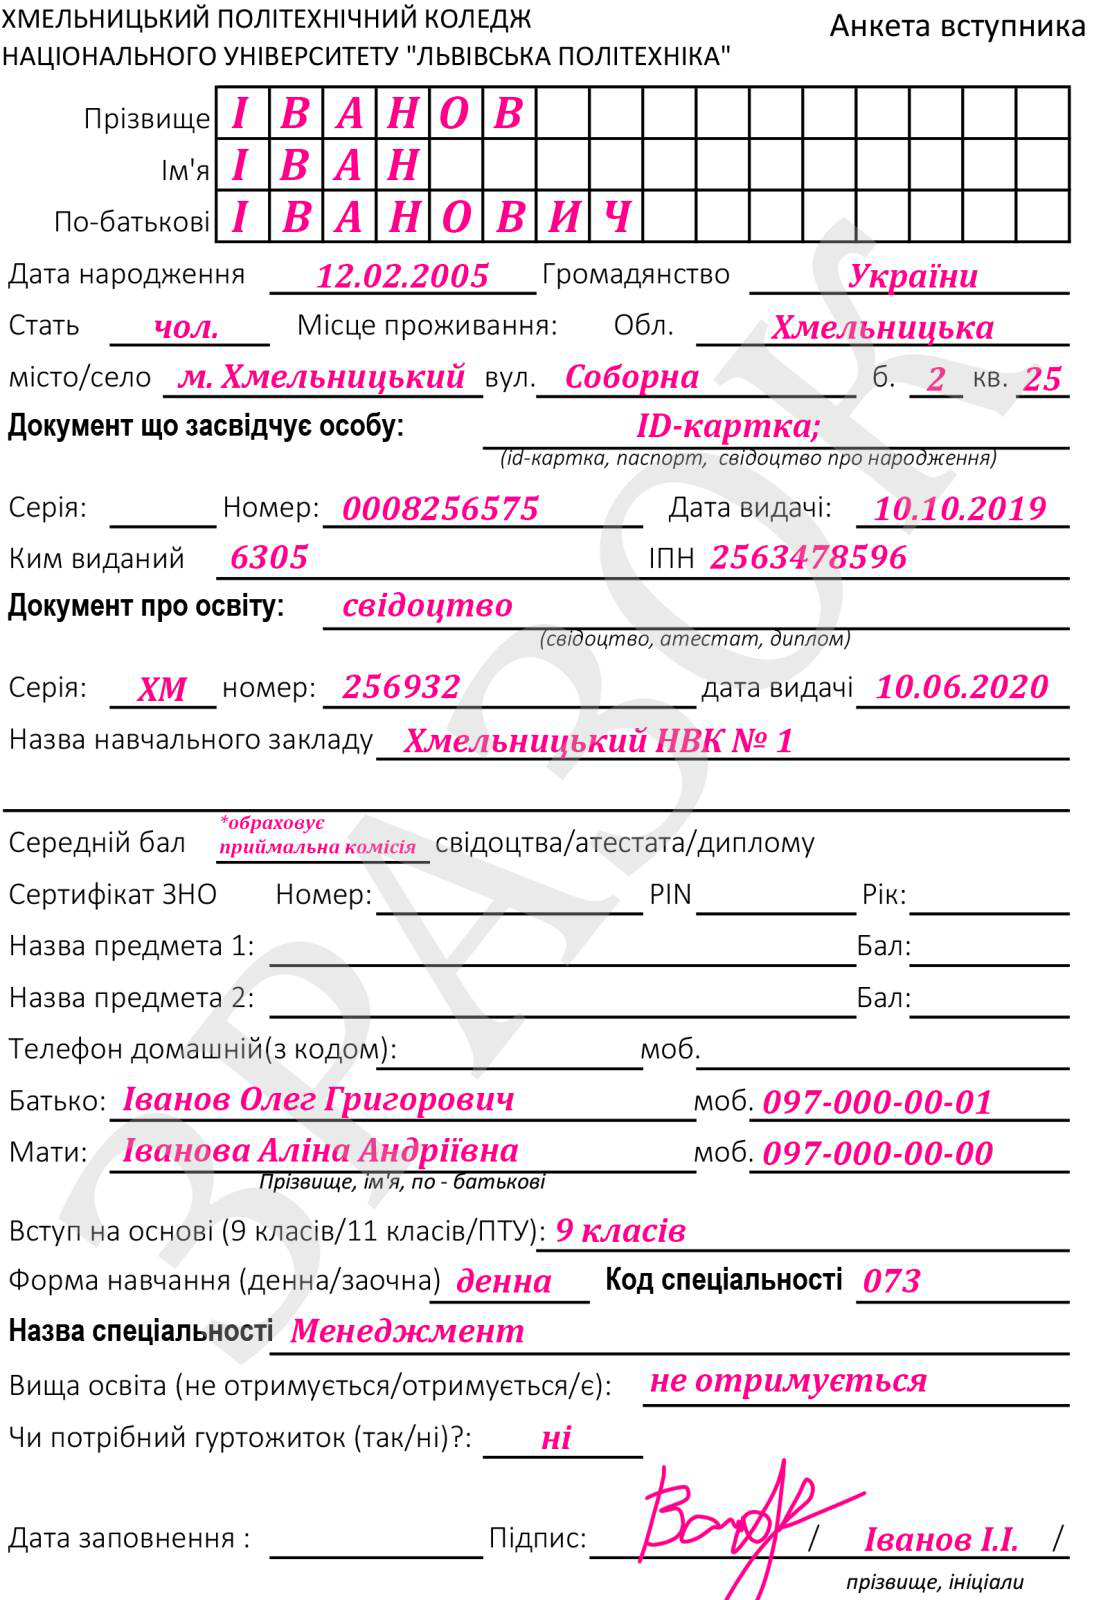

[
    {
        "nm": "HALIOHANIbHOTO YHIBEPCMTETY \"7IbBIBCbKA MONIITEXHIKA\"",
        "unitprice": {
            "nm": "IM'A I B A H n'o-GarbKOBi I B A H 0 B M y pata HapokkeHHA 12.02.2005 PoMa AHCTBO ykpaiHU CTATb MOJI, Micue npoxMBahHA: 06n. Xmenbhuubha"
        },
        "cnt": [
            {
                "unitprice": "6. 2",
                "nm": "AOKYMeHT mo 3aCBiA4YE oco6y: (id-kapmika, nochopm, celoumco npo HappoireNHA) Cepia: Homep: 0008256575"
            },
            {
                "nm": "AOKYMeHT mo 3aCBiA4YE oco6y: (id-kapmika, nochopm, celoumco npo HappoireNHA) Cepia: Homep: 0008256575"
            }
        ],
        "price": "10,2019"
    },
    {
        "nm": "Ha3Ba cneujaNbHOCTI MeHeoHocMeHmenia OCHOICHI OCB OTPIOHUMYTbCA/e): He ompumyembCR Hnwa ocBiTA (He TMPUMYTbCA/OTDMMyetbCA/e):",
        "unitprice": [
            "(9 KnaciB/11 KnaciB/MTY): 9 KnaciB",
            "Kop cneujaNbHOCTI 073"
        ]
    }
]


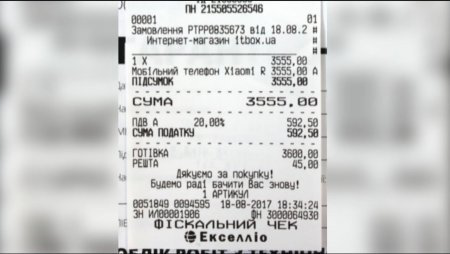

{
    "menu": [
        {
            "nm": "TH 215585526546",
            "num": "00001",
            "cnt": "1",
            "price": "01"
        },
        {
            "nm": "WHTEPHET-Mara3MH",
            "unitprice": "18box.ua",
            "cnt": "1 X",
            "price": "3555,00"
        },
        {
            "nm": "MO61/DHOA Teneton Xiaomi R",
            "unitprice": "3555,00",
            "cnt": "1 X",
            "price": "3555,00"
        },
        {
            "nm": "NIACHMON",
            "unitprice": "3555,00",
            "cnt": "1 x",
            "price": "3555,00"
        },
        {
            "nm": "CYM A",
            "unitprice": "3555,00",
            "cnt": "1 x",
            "price": "592.50"
        },
        {
            "nm": "NABA",
            "unitprice": "20,000",
            "cnt": "1 x",
            "price": "582.50"
        }
    ],
    "sub_total": {
        "subtotal_price": "3600,000",
        "tax_price": "45,00",
        "etc": [
 

In [21]:
import json

for sequence, image in zip(sequences, images):
  parsed = processor.token2json(sequence)
  display(image)
  print(json.dumps(parsed, indent=4))